to do:
definire per ogni immagine graph embedding della mano a partire da hand landmarks;
creare dataset torch per ogni immagine;
creare graph convolutional network (gcn);
validare gcn

In [ ]:
!pip install mediapipe
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import torchvision
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import copy
import cv2
#from google.colab.patches import cv2_imshow
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#import mediapipe as mp
#from mediapipe.tasks import python
#from mediapipe.tasks.python import vision
import math
import pandas as pd
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

torch.manual_seed(42)
path_model = os.path.join(os.getcwd(), 'saved_models')

print("Current device:", device)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
  print(" Type:", torch.cuda.get_device_name(0))

Current device: cuda
 Type: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
from google.colab import drive
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive/Multimodal/Colabs"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/asl_dataset"
GDRIVE_MODEL_DIR = GDRIVE_HOME_DIR + '/Models'

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [2]:
class ASLDataset(Dataset):
    def __init__(self,  img_dir, skeleton=False):
      if skeleton:
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

      labels_cat = sorted([dir for dir in os.listdir(img_dir)])
      _,labels_int = np.unique(labels_cat, return_inverse=True)
      labels_dict = {labels_cat[i]: labels_int[i] for i in range(len(labels_cat))}
      self.labels = []
      self.gestures = []
      counts_si = {dir:0 for dir in os.listdir(img_dir)}
      counts_no = {dir:0 for dir in os.listdir(img_dir)}
      for dir in os.listdir(img_dir):
          path = os.path.join(img_dir,dir)
          for image in os.listdir(path):

            path_img = os.path.join(path,image)
            if skeleton:
              try:
                gesture= self.detectLandmarks(path_img)
              except:
                continue
              else:
                self.gestures.append(gesture)
                self.labels.append(self.one_hot_label(labels_dict[dir]))
            else:
              img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB)
              self.gestures.append(img)
              self.labels.append(labels_dict[dir])


    def detectLandmarks(self,path_img):
      img = cv2.imread(path_img)
      image_height, image_width, _ = img.shape
      results = self.hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      features = {}
      k=0

      if results.multi_hand_landmarks:

        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
          for i in range(21):
              #print(f'{self.mp_hands.HandLandmark(i).name}')
              x = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].x * image_width
              y = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].y * image_height
              z = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].z * image_width
              x_hat = x / z
              y_hat = y / z
              r = math.sqrt(x**2 + y**2 + z**2)
              theta = math.acos(z/r)
              phi = math.atan(y/x)
              ro = math.sqrt(x_hat**2+y_hat**2)
              theta_hat = math.atan(y/x)
              features[i] = [x,y,z,r,theta,phi,x_hat,y_hat,ro,theta_hat]
      else:
        raise Exception("No landmarks detected")

      return np.array(list(features.values()))

    def __len__(self):
        return len(self.gestures)

    def __getitem__(self, idx):
        return self.gestures[idx], self.labels[idx]

    def one_hot_label(self,i, nclass=36):
        t = torch.zeros(nclass)
        t[i] = 1
        return t
#dataset = ASLDataset(f'{os.getcwd()}/asl_dataset')

# Graph Models

In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True, init='xavier'):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        if init == 'uniform':
            #print("| Uniform Initialization")
            self.reset_parameters_uniform()
        elif init == 'xavier':
            #print("| Xavier Initialization")
            self.reset_parameters_xavier()
        elif init == 'kaiming':
            #print("| Kaiming Initialization")
            self.reset_parameters_kaiming()
        else:
            raise NotImplementedError

    def reset_parameters_uniform(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def reset_parameters_kaiming(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GraphAttention(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttention, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(in_features, out_features).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)
        self.a1 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(out_features, 1).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)
        self.a2 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(out_features, 1).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        N = h.size()[0]

        f_1 = torch.matmul(h, self.a1)
        f_2 = torch.matmul(h, self.a2)
        e = self.leakyrelu(f_1 + f_2.transpose(0,1))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, init):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid, init=init)
        self.gc2 = GraphConvolution(nhid, nclass, init=init)
        self.dropout = dropout

    def bottleneck(self, path1, path2, path3, adj, in_x):
        return F.relu(path3(F.relu(path2(F.relu(path1(in_x, adj)), adj)), adj))

    def forward(self, x, adj):
        x = F.dropout(F.relu(self.gc1(x, adj)), self.dropout, training=self.training)
        x = self.gc2(x, adj)
        x = torch.mean(x, dim=0, keepdim=True)
        return F.log_softmax(x, dim=1)

class GCN_drop_in(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, init):
        super(GCN_drop_in, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid, init=init)
        self.gc2 = GraphConvolution(nhid, nclass, init=init)
        self.dropout = dropout

    def bottleneck(self, path1, path2, path3, adj, in_x):
        return F.relu(path3(F.relu(path2(F.relu(path1(in_x, adj)), adj)), adj))

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.dropout(F.relu(self.gc1(x, adj)), self.dropout, training=self.training)
        x = self.gc2(x, adj)

        return F.log_softmax(x, dim=1)

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttention(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttention(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

# Training GCN

Definizione matrice di adiacenza per rappresentare grafo della mano (prima definzione grafo da lista di adiacenza)

In [ ]:
G = {i:[] for i in range(21) }
G[0] = [1,5,9,13,17] #polso
G[1] = [0,2] #base pollice
G[2] = [1,3,4,19] #terzo joint pollice
G[3] = [2,4] #secondo joint pollice
G[4] = [2,3,5] # punta pollice
G[5] = [0,4,6]
G[6] = [5,7,8,19]
G[7] = [6,8]
G[8] = [6,7,9]
G[9] = [0,8,10]
G[10] = [9,11,12,19]
G[11] = [10,12]
G[12] = [10,11,13]
G[13] = [0,12,14]
G[14] = [13,15,16,19]
G[15] = [14,16]
G[16] = [14,15,17]
G[17] = [0,16,18]
G[18] = [17,19,20]
G[19] = [2,6,10,14,18,20]
G[20] = [18,19]

def adj_matrix_from_list(G: dict) -> np.ndarray:
  n = len(G.keys())
  A = np.zeros([n,n])
  for u in G.keys():
    for v in G[u]:
      A[u][v] = 1
  return A

def adj_matrix_scaling(A: np.ndarray) -> np.ndarray:
    return A /A.sum(axis=1)[:,None]

adj = adj_matrix_from_list(G)
adj = torch.tensor(adj_matrix_scaling(adj))

In [ ]:
import time
import random
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


"""
N : number of nodes
D : number of features per node
E : number of classes

@ input :
    - adjacency matrix (N x N)
    - feature matrix (N x D)
    - label matrix (N x E)

"""

# Data upload
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

nclass = len([dir for dir in os.listdir(GDRIVE_DATA_DIR)])
use_gpu = torch.cuda.is_available()

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if use_gpu:
    torch.cuda.manual_seed(42)

model, optimizer = None, None
best_acc = 0
opt_model = 'basic'
# Define the model and optimizer
if (opt_model == 'basic'):
    print("| Constructing basic GCN model...")
    model = GCN(
            nfeat = train_dataset[0][0].shape[1],
            nhid = 8,
            nclass = nclass,
            dropout = 0.6,
            init = 'xavier'
    )
elif (opt_model == 'attention'):
    print("| Constructing Attention GCN model...")
    model = GAT(
            nfeat = train_dataset[0][0].shape[1],
            nhid = 8,
            nclass = nclass,
            dropout = 0.6,
            nheads = 8,
            alpha = 0.2
    )
else:
    raise NotImplementedError

batch_size = 1
optimizer = optim.SGD(model.parameters(), lr = 5e-3, weight_decay = 5e-4, momentum = 0.9)
#optimizer = optim.Adam(model.parameters(), lr = 5e-3,weight_decay = 5e-4)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

if use_gpu:
    model.cuda()
    #features, adj, labels, idx_train, idx_val, idx_test = list(map(lambda x: x.cuda(), [features, adj, labels, idx_train, idx_val, idx_test]))


save_point = GDRIVE_MODEL_DIR


def lr_scheduler(epoch, lr, lr_decay_epoch):
    return lr * (0.5 ** (epoch / lr_decay_epoch))

# Train
for epoch in range(800):
    #global best_acc

    t = time.time()
    model.train()
    optimizer.lr = lr_scheduler(epoch,5e-3, 5000)
    optimizer.zero_grad()

    #output = model(features, adj)
    #loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    #acc_train = accuracy(output[idx_train], labels[idx_train])

    #loss_train.backward()
    #optimizer.step()
    total_loss = 0
    for i, (input, label) in enumerate(train_loader):
      input, adj, label = list(map(lambda x: Variable(x), [input,adj,label]))
      if use_gpu:
        input,adj,label = list(map(lambda x: x.cuda(), [input,adj,label]))
      #input= input.to(device)
      out = model(input[0].float(),adj.float())
      #print(out, label)
      #print(torch.argmax(out, keepdim=True).shape,torch.argmax(label, keepdim=True).squeeze(1).shape)
      l = F.nll_loss(out,torch.argmax(label, keepdim=True).squeeze(1))
      l.backward()
      total_loss += l.item()
      optimizer.step()

    if (epoch+1) % 5 == 0:
      #print (f'Epoch [{epoch+1}/{n_epochs}], Loss: {l.item():.4f}')
      average_loss = total_loss / len(train_loader)
      print(f'Epoch [{epoch+1}], Loss: {average_loss:.4f}')
      #print(average_loss)

    # Validation for each epoch
    #model.eval()
    #output = model(features, adj)
    #loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    #acc_val = accuracy(output[idx_val], labels[idx_val])
    '''
    if acc_val > best_acc:
        best_acc = acc_val
        state = {
            'model': model,
            'acc': best_acc,
            'epoch': epoch,
        }

        torch.save(state, os.path.join(save_point, '%s.t7' %(opt_model)))
    '''
    #print("=> Training Epoch #{} : lr = {:.4f}".format(epoch, optimizer.lr))
    #print(" | Training acc : {:6.2f}%".format(acc_train.data.cpu().numpy() * 100))
    #print(" | Best acc : {:.2f}%". format(best_acc.data.cpu().numpy() * 100))

In [ ]:
model.eval()
features, labels = list(map(lambda x: np.array(x),[[x[0] for x in test_dataset], [x[1] for x in test_dataset]]))
n = features.shape[0]
output = model(torch.from_numpy(features), adj[None,:].repeat(n,1,1))
acc_test = accuracy(output, labels)
print("| Test acc : {}%\n".format(acc_test.data.cpu().numpy() * 100))

<ipython-input-39-08ee8428d2e0>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  features, labels = list(map(lambda x: np.array(x),[[x[0] for x in test_dataset], [x[1] for x in test_dataset]]))
<ipython-input-39-08ee8428d2e0>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features, labels = list(map(lambda x: np.array(x),[[x[0] for x in test_dataset], [x[1] for x 

RuntimeError: ignored

# pretrain

In [11]:
model_accs = {}
dataset = ASLDataset(os.path.join(os.getcwd(), 'asl_dataset'))
training = False
# Carica i dati del nuovo dataset
#image_datasets = {x: datasets.ImageFolder(f'{data_dir}/{x}', data_transforms[x]) for x in ['train', 'val']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
# Data upload
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
nclass = len([dir for dir in os.listdir(os.path.join(os.getcwd(),'asl_dataset'))])
first_run = True
# Carica il modello VGG16 preaddestrato
model = models.vgg16(pretrained=True)

# Imposta i parametri del modello come non addestrabili
for param in model.parameters():
    param.requires_grad = False

# Sostituisci il classificatore (fully connected) finale per adattarlo al nuovo dataset
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, nclass)

if not first_run:
  model.load_state_dict(torch.load(os.path.join(os.getcwd(), f'vgg16_epoch3.pth')))
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Utilizza GPU se disponibile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#optimizer = optim.Adam(model.parameters(), lr = 5e-3,weight_decay = 5e-4)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=10,
                                              shuffle=False)

#optimizer = optim.Adam(model.parameters(), lr = 5e-3,weight_decay = 5e-4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=10,
                                              shuffle=False)
# Addestramento del modello

if training:
    num_epochs = 100
    best_acc = 0
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            #print(inputs.shape,labels)
            optimizer.zero_grad()
            inputs = torch.einsum('ijkl -> iljk', inputs)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Valutazione del modello
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = torch.einsum('ijkl -> iljk', inputs)
                outputs = model(inputs.float())
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        epoch_loss = running_loss / len(test_loader)
        accuracy = correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {accuracy * 100:.2f}%')
        model_accs[str(epoch)] = accuracy * 100
        if best_acc < model_accs[str(epoch)]:
            best_acc = accuracy * 100
            torch.save(model.state_dict(), os.path.join(path_model, f'vgg16_bestacc.pth'))
        model.train()

    # Salvataggio del modello addestrato
    torch.save(model.state_dict(),os.path.join(path_model, 'vgg16_addestrato.pth'))


C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
acc_json = json.dumps(model_accs, indent=4)
with open(os.path.join(path_model, 'resnet50_accuracies.json'),'w') as file:
    file.write(acc_json)

C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 95.10%


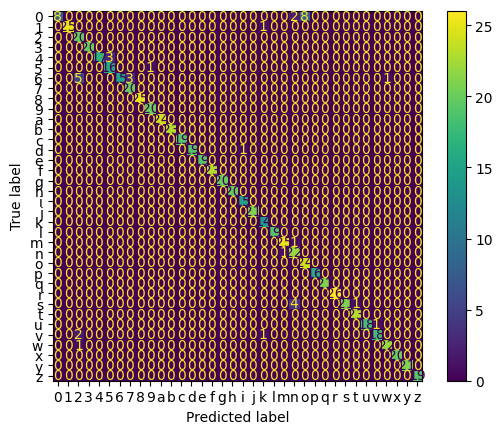

In [18]:
model = models.vgg16(pretrained=True).to(device)
classes = [dir for dir in os.listdir(os.path.join(os.getcwd(),'asl_dataset'))]
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(classes)).to(device)
model.load_state_dict(torch.load(os.path.join(path_model, 'vgg16_bestacc.pth')))
model.eval()
correct = 0
total = 0
y_pred = []
y_ground_truth = []
with torch.no_grad():
    for inputs, labels in test_loader:
        y_ground_truth = y_ground_truth + labels.tolist()
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = torch.einsum('ijkl -> iljk', inputs)
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.tolist()
        correct += (predicted == labels).sum().item()



accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')
cm= confusion_matrix(y_ground_truth,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

In [20]:
training=True
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclass) 


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 5e-3,weight_decay = 5e-4)
# Utilizza GPU se disponibile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
'''
#
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=10,
                                              shuffle=False)

#optimizer = optim.Adam(model.parameters(), lr = 5e-3,weight_decay = 5e-4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=10,
                                              shuffle=False)
                                              '''
# Addestramento del modello

if training:
    num_epochs = 100
    best_acc = 0
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            #print(inputs.shape,labels)
            optimizer.zero_grad()
            inputs = torch.einsum('ijkl -> iljk', inputs)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Valutazione del modello
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = torch.einsum('ijkl -> iljk', inputs)
                outputs = model(inputs.float())
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        epoch_loss = running_loss / len(test_loader)
        accuracy = correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {accuracy * 100:.2f}%')
        model_accs[str(epoch)] = accuracy * 100
        if best_acc < model_accs[str(epoch)]:
            best_acc = accuracy * 100
            torch.save(model.state_dict(), os.path.join(path_model, f'resnet50_bestacc.pth'))
        model.train()

C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Loss: 1.7870 - Accuracy: 51.92%
Epoch [2/100] - Loss: 1.2123 - Accuracy: 64.11%
Epoch [3/100] - Loss: 1.0365 - Accuracy: 63.18%
Epoch [4/100] - Loss: 1.3335 - Accuracy: 58.68%
Epoch [5/100] - Loss: 0.8733 - Accuracy: 70.46%
Epoch [6/100] - Loss: 1.1811 - Accuracy: 70.20%
Epoch [7/100] - Loss: 0.8358 - Accuracy: 76.42%
Epoch [8/100] - Loss: 0.8990 - Accuracy: 76.82%
Epoch [9/100] - Loss: 1.2546 - Accuracy: 70.73%
Epoch [10/100] - Loss: 0.9099 - Accuracy: 77.22%
Epoch [11/100] - Loss: 1.3314 - Accuracy: 74.30%
Epoch [12/100] - Loss: 0.8696 - Accuracy: 79.07%
Epoch [13/100] - Loss: 1.2392 - Accuracy: 76.03%
Epoch [14/100] - Loss: 1.3999 - Accuracy: 73.91%
Epoch [15/100] - Loss: 1.0102 - Accuracy: 79.87%
Epoch [16/100] - Loss: 0.9703 - Accuracy: 78.41%
Epoch [17/100] - Loss: 1.4440 - Accuracy: 70.99%
Epoch [18/100] - Loss: 0.9008 - Accuracy: 79.34%
Epoch [19/100] - Loss: 0.4891 - Accuracy: 85.70%
Epoch [20/100] - Loss: 0.6456 - Accuracy: 83.44%
Epoch [21/100] - Loss: 0.6975

C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nosen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 90.86%


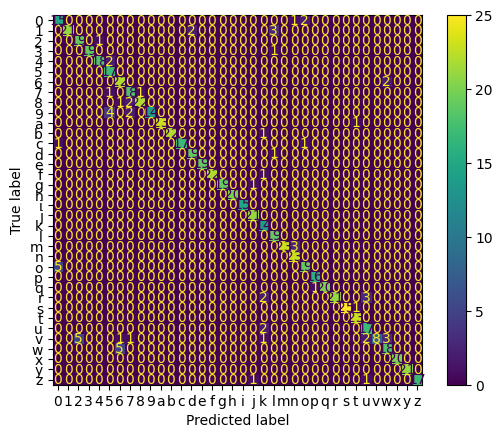

In [24]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclass) .to(device)
model.load_state_dict(torch.load(os.path.join(path_model, 'resnet50_bestacc.pth')))
model.eval()
correct = 0
total = 0
y_pred = []
y_ground_truth = []
with torch.no_grad():
    for inputs, labels in test_loader:
        y_ground_truth = y_ground_truth + labels.tolist()
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = torch.einsum('ijkl -> iljk', inputs)
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.tolist()
        correct += (predicted == labels).sum().item()



accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')
cm= confusion_matrix(y_ground_truth,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

# old

In [ ]:
def plot_images(images):
    plt.figure(figsize=(2,2))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1),
    ], dim=-2))
    plt.show()


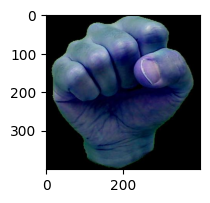

In [ ]:
#from IPython.display import display
path = GDRIVE_DATA_DIR + '/s/hand5_s_dif_seg_5_cropped.jpeg'
img = cv2.imread(path)
#img = df_sign.iloc[0][1:].to_numpy().reshape(28,28)
#img = img.astype(np.uint8)
#img = Image.fromarray(img)
#display(img)
images = torch.tensor(img)[None,:,:]
plot_images(images)

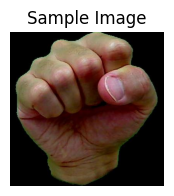

In [ ]:
# First step is to initialize the Hands class an store it in a variable
mp_hands = mp.solutions.hands

# Now second step is to set the hands function which will hold the landmarks points
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

# Last step is to set up the drawing function of hands landmarks on the image
mp_drawing = mp.solutions.drawing_utils
# Here we are specifing the size of the figure i.e. 10 -height; 10- width.
plt.figure(figsize = [2, 2])

# Here we will display the sample image as the output.
plt.title("Sample Image");plt.axis('off');plt.imshow(img[:,:,::-1]);plt.show()

In [ ]:
image_height, image_width, _ = img.shape
results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

if results.multi_hand_landmarks:

    for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):

        print(f'HAND NUMBER: {hand_no+1}')
        print('-----------------------')

        for i in range(2):
            print(f'{mp_hands.HandLandmark(i).name}:')
            print(f'x: {hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x * image_width}')
            print(f'y: {hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y * image_height}')
            print(f'z: {hand_landmarks.landmark[mp_hands.HandLandmark(i).value].z * image_width}n')

In [ ]:
img_copy = img.copy()

if results.multi_hand_landmarks:

    for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):

        mp_drawing.draw_landmarks(image = img_copy, landmark_list = hand_landmarks,
                                  connections = mp_hands.HAND_CONNECTIONS)
    fig = plt.figure(figsize = [2, 2])

    plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

In [ ]:
#MNIST
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Dataset MNIST/sign_mnist_train/"

class ASLDataset(Dataset):
    def __init__(self,  img_dir):
      self.mp_hands = mp.solutions.hands
      self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

      self.labels = []
      self.gestures = []
      count_si = {}
      count_no = {}
      df_train = pd.read_csv(GDRIVE_DATA_DIR+'/sign_mnist_train.csv')
      for idx, row in df_train.iterrows():
        label = row['label']
        if  label not in counts.keys():
          counts[label] = [0,0]
        img = row[1:].to_numpy().reshape(28,28,1)
        gesture, found = self.detectLandmarks(img)
        if found:
           counts[label][0]+=1
        else:
            counts[label][1]+=1

      print(sum(list(map(lambda x: x[0],counts.values()))),sum(list(map(lambda x: x[1], counts.values()))),counts)

    def detectLandmarks(self,img):
      img = img.astype(np.uint8)
      image_height, image_width, _ = img.shape
      results = self.hands.process(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
      features = {}
      k=0

      if results.multi_hand_landmarks:

        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
          for i in range(21):
              #print(f'{self.mp_hands.HandLandmark(i).name}')
              x = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].x * image_width
              y = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].y * image_height
              z = hand_landmarks.landmark[self.mp_hands.HandLandmark(i).value].z * image_width
              x_hat = x / z
              y_hat = y / z
              r = math.sqrt(x**2 + y**2 + z**2)
              theta = math.acos(z/r)
              phi = math.atan(y/x)
              ro = math.sqrt(x_hat**2+y_hat**2)
              theta_hat = math.atan(y/x)
              features[i] = [x,y,z,r,theta,phi,x_hat,y_hat,ro,theta_hat]
      else:
        return None, False

      return np.array(list(features.values())), True

    def __len__(self):
        return len(self.gestures)

    def __getitem__(self, idx):
        return self.gestures[idx], self.labels[idx]

dataset = ASLDataset(GDRIVE_DATA_DIR)

743 27492 {3: [4, 1227], 6: [15, 1111], 2: [4, 1180], 13: [36, 1142], 16: [11, 1308], 8: [120, 1068], 22: [15, 1236], 18: [20, 1217], 10: [0, 1144], 20: [26, 1168], 17: [32, 1291], 19: [2, 1231], 21: [27, 1087], 23: [60, 1142], 24: [47, 1092], 1: [64, 974], 12: [54, 1026], 11: [34, 1254], 15: [12, 1111], 4: [96, 891], 0: [44, 1117], 5: [11, 1221], 7: [0, 1034], 14: [9, 1220]}
